Adaptacion de modelo tomado de https://apmonitor.com/dde/index.php/Main/LLMTransformers con datos de Shanghai. Version 2

Modificacion: Positional Encoding

In [191]:
#Veamos si la grafica esta disponible
import torch
import math
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

# Configurar el dispositivo GPU para utilizarlo en lugar del CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

True
NVIDIA GeForce RTX 2060 SUPER
Usando dispositivo: cuda


In [192]:
#Carguemos los datos
import pandas as pd
ShanghaiDat=pd.read_csv('Shanghai-2005-2025.csv')
ShanghaiDat=ShanghaiDat.drop(ShanghaiDat.columns[0], axis=1)

In [193]:
#Debemos convertir nuestros datos en una ventana de datos deslizantes.
import numpy as np

# Convertimos los datos a un array de 1 dimension
ShanghaiDat = np.array(ShanghaiDat).flatten()

#Aplicamos MinMaxScaler a los datos
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ShanghaiDat = scaler.fit_transform(ShanghaiDat.reshape(-1, 1)).flatten()


In [194]:
#Funcion que divide en epocas de n dias
def Epocas(sequence_length=12):
    size = len(ShanghaiDat) 
    sequences = [ShanghaiDat[i:i+sequence_length] for i in range(size-sequence_length)]
    next_points = ShanghaiDat[sequence_length:]

    # Convertir a NumPy arrays correctamente
    return np.array(sequences), np.array(next_points)

In [195]:
#Terminamos de cargar todas las librerias que vamos a usar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, next_points):
        self.sequences = sequences
        self.next_points = next_points

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.next_points[idx]

In [196]:
#Postional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len):
        super().__init__()
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) *
            -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        return x + self.pe[:, :x.size(1)]


In [197]:
# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, sequence_length=12, d_model=512, num_layers=2, num_heads=4, dim_feedforward=512):
        super().__init__() 
        self.sequence_length = sequence_length
        self.input_proj = nn.Linear(input_size, d_model) #Se proyecta cada punto de la serie al espacio d_model (Equivalente al embbeding)
        self.pos_encoder = PositionalEncoding(d_model, sequence_length) #Se aplica el positional encoding
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=dim_feedforward) #Se define una capa de encoder
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_layers) #Se aplican las capas deseadas
        self.fc_out = nn.Linear(d_model * sequence_length, 1) #cada valor en el sequence lenght tiene una respresetacion en el espacio de 512 dimensiones

    def forward(self, src):
        # src: [batch_size, sequence_length]
        x = src.unsqueeze(-1)                         # [batch, seq_len, 1]
        x = self.input_proj(x)                        # [batch, seq_len, d_model]
        x = self.pos_encoder(x)                       # [batch, seq_len, d_model]
        x = x.permute(1, 0, 2)                        # [seq_len, batch, d_model]
        out = self.transformer_encoder(x)             # [seq_len, batch, d_model]
        out = out.permute(1, 0, 2).contiguous()       # [batch, seq_len, d_model]
        out = out.view(out.size(0), -1)               # [batch, seq_len*d_model]
        return self.fc_out(out)                       # [batch, 1]

In [198]:
# Preparamos los datos
sequences, next_points = Epocas()
dataset = TimeSeriesDataset(sequences, next_points) 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [199]:
#Entrenamiento del modelo
model = TransformerModel().to(device)
criterion = nn.MSELoss() #Funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Optimizador

# Training loop
losses=[]
for epoch in range(300):
    for seq, next_point in dataloader:
        seq, next_point = seq.float().to(device), next_point.float().unsqueeze(1).to(device) 
        output = model(seq)
        loss = criterion(output, next_point) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss)

C:\Users\Antonio Rojas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.021358808502554893
Epoch 2, Loss: 0.01568673923611641
Epoch 3, Loss: 0.015641968697309494
Epoch 4, Loss: 0.008262007497251034
Epoch 5, Loss: 0.009370625950396061
Epoch 6, Loss: 0.0062125446274876595
Epoch 7, Loss: 0.0074457102455198765
Epoch 8, Loss: 0.00927956122905016
Epoch 9, Loss: 0.002324481029063463
Epoch 10, Loss: 0.006617748644202948
Epoch 11, Loss: 0.006817537825554609
Epoch 12, Loss: 0.0025644851848483086
Epoch 13, Loss: 0.003148181363940239
Epoch 14, Loss: 0.0009758693631738424
Epoch 15, Loss: 0.0032426544930785894
Epoch 16, Loss: 0.0013804966583848
Epoch 17, Loss: 0.0016279628034681082
Epoch 18, Loss: 0.0009463597671128809
Epoch 19, Loss: 0.0018926962511613965
Epoch 20, Loss: 0.0019323648884892464
Epoch 21, Loss: 0.00043240439845249057
Epoch 22, Loss: 0.0007973529864102602
Epoch 23, Loss: 0.0005632987013086677
Epoch 24, Loss: 0.00044037046609446406
Epoch 25, Loss: 0.0005543993902392685
Epoch 26, Loss: 0.00034374993992969394
Epoch 27, Loss: 0.000497190980240

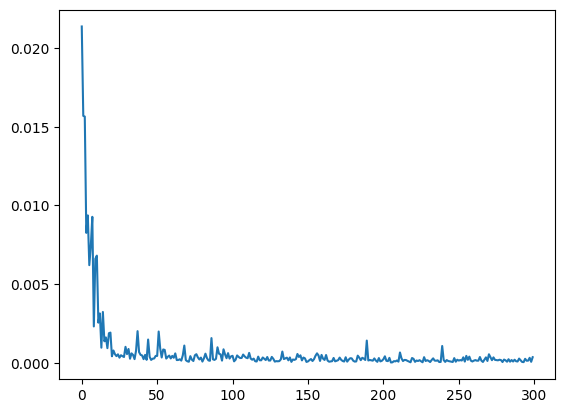

In [200]:
import matplotlib.pyplot as plt

losses = [loss.detach().cpu().item() for loss in losses]
losses = np.array(losses)

plt.plot(losses)
plt.show()

In [208]:
# Veamos cómo predice el modelo

# Tomamos una secuencia ya escalada (por ejemplo, la primera del dataset)
test_seq = sequences[0].reshape(-1, 1)  # La convertimos a forma columna
test_seq = scaler.transform(test_seq).flatten()  # La reescalamos (aunque ya estaba escalada, es por claridad y generalidad)

# Convertimos a tensor y agregamos dimensión de batch
test_seq_tensor = torch.tensor(test_seq).float().unsqueeze(0).to(device)

# Obtenemos la predicción del modelo
with torch.no_grad():
    predicted_scaled = model(test_seq_tensor)

# Convertimos de vuelta a numpy
predicted_scaled_np = predicted_scaled.cpu().numpy()

# Desescalamos la predicción a su valor original
predicted_real = scaler.inverse_transform(predicted_scaled_np)

print("Predicción (dato siguiente real):", predicted_real.item())
print("Dato siguiente real original:", scaler.inverse_transform([[next_points[0]]])[0][0])


Predicción (dato siguiente real): 448.29034423828125
Dato siguiente real original: 1204.39404296875
